In [1]:
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

try:
    import flygym
    FLYGYM_INSTALLED = True
except ImportError:
    FLYGYM_INSTALLED = False

if IN_COLAB:
    print("In Google Colab. I will now perform some Colab-specific setups.")
    # Set up GPU a few more and rendering parameters. This should take ~1 second.
    from google.colab import files
    import distutils.util
    import os
    import subprocess

    if subprocess.run("nvidia-smi").returncode:
        raise RuntimeError(
            "Cannot communicate with GPU. "
            "Make sure you are using a GPU Colab runtime. "
            "Go to the Runtime menu and select Choose runtime type."
        )

    # Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
    # This is usually installed as part of an Nvidia driver package, but the Colab
    # kernel doesn't install its driver via APT, and as a result the ICD is missing.
    # (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
    NVIDIA_ICD_CONFIG_PATH = "/usr/share/glvnd/egl_vendor.d/10_nvidia.json"
    if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
        with open(NVIDIA_ICD_CONFIG_PATH, "w") as f:
            f.write(
"""{
    "file_format_version" : "1.0.0",
    "ICD" : {
        "library_path" : "libEGL_nvidia.so.0"
    }
}
"""
            )

    # Configure MuJoCo to use the EGL rendering backend (requires GPU)
    print("Setting environment variable to use GPU rendering:")
    %env MUJOCO_GL=egl

    try:
        print("Checking that the installation succeeded:")
        import mujoco

        mujoco.MjModel.from_xml_string("<mujoco/>")
    except Exception as e:
        raise e from RuntimeError(
            "Something went wrong during installation. Check the shell output above "
            "for more information.\n"
            "If using a hosted Colab runtime, make sure you enable GPU acceleration "
            'by going to the Runtime menu and selecting "Choose runtime type".'
        )

    print("Installation successful.")

if not FLYGYM_INSTALLED:
    if IN_COLAB:
        print("FlyGym not installed. I will try to install it now.")
        import subprocess
        subprocess.run('pip install "flygym[examples]"')
    else:
        print(
            "FlyGym is not installed. I can try to install it here but I don't want "
            "to mess up your Python environment unintentionally. Please do it manually."
        )

# Getting started with FlyGym

In this example, we will demonstrate how one can control the fly in a physics simulation. As a "trivial" example, we will actuate all leg degrees of freedom (DoF) with sine waves (i.e., each DoF oscillates in a sinusoidal pattern). In reality, since such a leg actuation pattern is so unusual, we will likely encounter numerical stability issues that will lead to a crash of the simulation

The fly has a lot of DoFs. We will focus on the actively controlled leg DoFs. For each leg, there are seven of them:
- Thorax-coxa pitch
- Thorax-coxa roll
- Thorax-coxa yaw
- Coxa-femur pitch
- Coxa-femur roll
- Femur-tibia pitch
- Tibia-tarsus pitch

For convenience, we have hard-coded these DoFs in a hard-coded list that you can simply import:

In [2]:
from flygym.preprogrammed import all_leg_dofs

print(all_leg_dofs)

['joint_LFCoxa', 'joint_LFCoxa_roll', 'joint_LFCoxa_yaw', 'joint_LFFemur', 'joint_LFFemur_roll', 'joint_LFTibia', 'joint_LFTarsus1', 'joint_LMCoxa', 'joint_LMCoxa_roll', 'joint_LMCoxa_yaw', 'joint_LMFemur', 'joint_LMFemur_roll', 'joint_LMTibia', 'joint_LMTarsus1', 'joint_LHCoxa', 'joint_LHCoxa_roll', 'joint_LHCoxa_yaw', 'joint_LHFemur', 'joint_LHFemur_roll', 'joint_LHTibia', 'joint_LHTarsus1', 'joint_RFCoxa', 'joint_RFCoxa_roll', 'joint_RFCoxa_yaw', 'joint_RFFemur', 'joint_RFFemur_roll', 'joint_RFTibia', 'joint_RFTarsus1', 'joint_RMCoxa', 'joint_RMCoxa_roll', 'joint_RMCoxa_yaw', 'joint_RMFemur', 'joint_RMFemur_roll', 'joint_RMTibia', 'joint_RMTarsus1', 'joint_RHCoxa', 'joint_RHCoxa_roll', 'joint_RHCoxa_yaw', 'joint_RHFemur', 'joint_RHFemur_roll', 'joint_RHTibia', 'joint_RHTarsus1']


Let's generate the control signals for these 42 DoFs (6 legs, 7 DoFs per leg) — that is, 42 sine waves. We can generate these signals using NumPy:

In [3]:
import numpy as np

# Some parameters for the simulation
simulated_time = 1.0  # we will simulate 1 second of behavior
freq = 1  # let the DoFs oscillate at 10 Hz
amp = np.pi / 2  # let the amplitude of the oscillation be 90 deg
physics_dt = 1e-4  # we will simulate the physics at a time step of 0.0001s
num_steps = int(simulated_time / physics_dt)
num_dofs = 6 * 7  # 6 legs, 7 DoFs per leg

# Let's generate a time grid from 0s to 1s, with a spacing of 0.0001s
times = np.arange(num_steps) * physics_dt

# Now, we can generate the sine wave. This will be the deviation of DoF
# angles from the initial positions.
delta_dof_angles = amp * np.sin(2 * np.pi * freq * times)

print("Time grid:", times)
print("Delta Dof angles:", delta_dof_angles)

Time grid: [0.000e+00 1.000e-04 2.000e-04 ... 9.997e-01 9.998e-01 9.999e-01]
Delta Dof angles: [ 0.          0.00098696  0.00197392 ... -0.00296088 -0.00197392
 -0.00098696]


Let's visualize this:

Text(0.5, 1.0, 'Offset of DoF angles from initial positions')

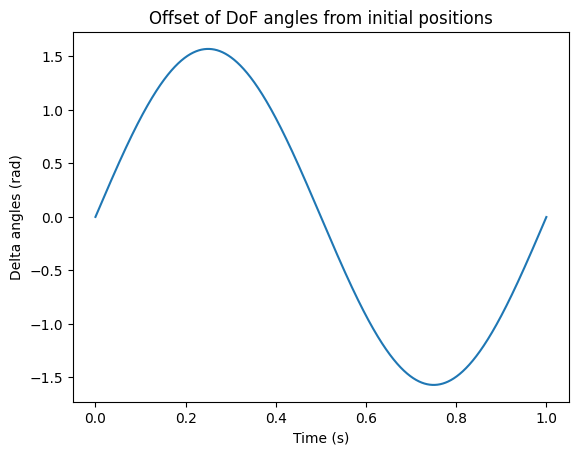

In [4]:
import matplotlib.pyplot as plt

plt.plot(times, delta_dof_angles)
plt.xlabel("Time (s)")
plt.ylabel("Delta angles (rad)")
plt.title("Offset of DoF angles from initial positions")

Now, we can set up the FlyGym simulation. We start by creating a `Fly` object:

In [5]:
from flygym import Fly

fly = Fly(
    name="Nuro",  # identifier for the fly
    spawn_pos=(0, 0, 10),  # we will drop the fly from a height of 10mm
    actuated_joints=all_leg_dofs,  # we will actuate all active leg DoFs
)

Then, we can create a `Camera` object to observe the fly:

In [6]:
from flygym import Camera

camera = Camera(
    fly=fly,  # attach the camera to the fly above
    camera_id="Animat/camera_left",  # use the left side view camera
    play_speed=0.1,  # replay the recording at 0.1x speed
    fps=30,  # the replay will be rendered at 30 FPS
             # (considering the 0.1x speed, we actually record at 300Hz)
    timestamp_text=True,  # add time stamp to the rendered images
    play_speed_text=True,  # also stamp the play speed on the images
)

With these, we can create a `Simulation` object:

In [7]:
from flygym import Simulation

sim = Simulation(
    flies=[fly],  # we can simulate multiple flies, but we only have one
    cameras=[camera],  # we can have multiple cameras, but we only have one
    timestep=physics_dt,  # set the dt of the physics simulation
)

The control of NeuroMechFly can be framed as a Partially Observable Markov Decision Process (POMDP). In such a process, at each time step:
- The **controller** (i.e. nervous system) receives an **observation** from the **task** (i.e. the physics simulation of NeuroMechFly). The observation may include proprioceptive signals, visual inputs, and other things depending on how the simulation is configured. Optionally, the controller also receives a **reward**.
- The controller makes a decision on what to do next, and apply this **action**. Depending on the level of abstraction of the model, the action can be the motor neuron drive, target joint position, etc.
- The **task** (i.e. the physics simulation) applies the action, and returns the next physics state to the controller as the new observation.

This process repeats in closed-loop. It is demonstrated in the figure below.

![NeuroMechFly control as a POMDP](https://github.com/NeLy-EPFL/_media/blob/main/flygym/nmf_schema_new.png?raw=true)

In our simulation, the task will return three additional pieces of information for the modeller's convenience:
- An arbitrary set of additional *information* that are configured by the modeller. This may include things that the fly cannot sense directly (though they may be estimated within the nervous system), but we as experimenters still want to know. Some examples are: the absolute global position of the fly, or the total distance walked.
- Whether or not the task has been *terminated* because a goal has been accomplished. This is particularly useful in reinforcement learning. If it is not applicable, one can make it always return False.
- Whether or not the task has been *truncated*. Unlike termination, the task is said to be truncated if we want to end the simulation because of factors that are not relevant to the task per se, but are set by the modeller. For example, we might set it to True if the simulation has exceeded the predefined maximum time, or if the fly has left the defined part of the arena.

Let's reset the simulation to get the initial observation (`obs`) and additional information (`info`):

In [8]:
obs, info = sim.reset()

The observation for our fly Nuro can be accessed with `obs["Nuro"]`. It is itself a dictionary consisting of many keys:

In [9]:
print(obs["Nuro"].keys())

dict_keys(['joints', 'fly', 'contact_forces', 'end_effectors', 'fly_orientation', 'cardinal_vectors'])


For example, we can access the current joint angles as follows. In this case, `obs["Nuro"]["joints"]` is a 4-by-N matrix, where the N is the number of actuated DoF. The top row of this matrix comprises the DoF angles. The complete definition of the observation space can be found in [FlyGym documentation](https://neuromechfly.org/api_ref/mdp_specs.html).

In [10]:
initial_dof_angles = obs["Nuro"]["joints"][0, :]
initial_dof_angles

array([ 0.33161256,  0.        ,  0.        , -2.268928  ,  0.        ,
        0.        ,  0.        ,  0.        ,  1.5707964 ,  0.        ,
       -1.7453293 ,  0.        ,  0.        ,  0.        ,  0.        ,
        2.6179938 ,  0.        , -1.7453293 ,  0.        ,  0.        ,
        0.        ,  0.33161256,  0.        ,  0.        , -2.268928  ,
        0.        ,  0.        ,  0.        ,  0.        , -1.5707964 ,
        0.        , -1.7453293 ,  0.        ,  0.        ,  0.        ,
        0.        , -2.6179938 ,  0.        , -1.7453293 ,  0.        ,
        0.        ,  0.        ], dtype=float32)

Next, we can add these initial angles to our delta angles to get the target angle for each DoF:

In [11]:
target_dof_angles = np.zeros(shape=(num_dofs, num_steps))
for i in range(num_dofs):
    target_dof_angles[i, :] = initial_dof_angles[i] + delta_dof_angles

Now, we can finally run the main simulation loop using the control signal obtained above. We will do this while recording the observation history. Instead of the standard `range`, we will use `tqdm.trange` to print a progress bar.

In [12]:
obs_hist = []  # Make an empty list to record observations

for i in range(num_steps):
    # The action is nested dictionary. On the first layer, we specify the
    # action performed by each of the simulated flies (in this case, just
    # Nuro). On the second layer, we specify different types of actions (in
    # this case, we only have joint actions, but in general there can also
    # be things like leg adhesion on/off).
    action = {"Nuro": {"joints": target_dof_angles[:, i]}}

    # Apply the action and get the new observation, etc.
    obs, reward, terminated, truncated, info = sim.step(action)

    # Don't forget to apply `sim.render()` to record the scene using the
    # camera(s) specified in the beginning.
    sim.render()

    obs_hist.append(obs)  # record observation

PhysicsError: Physics state is invalid. Warning(s) raised: mjWARN_BADQACC

We got some results but as expected, the physics simulation crashed shortly after the start. Nonetheless, let's check we have. We will plot the time series of the actual angles of all DoFs on one leg. We will overlay them on top of the control signal (i.e. target angles). They won't be completely identical because the joints and actuators have finite stiffness and gain.

Text(0.5, 1.0, 'Target and actual DoF angles, one leg only')

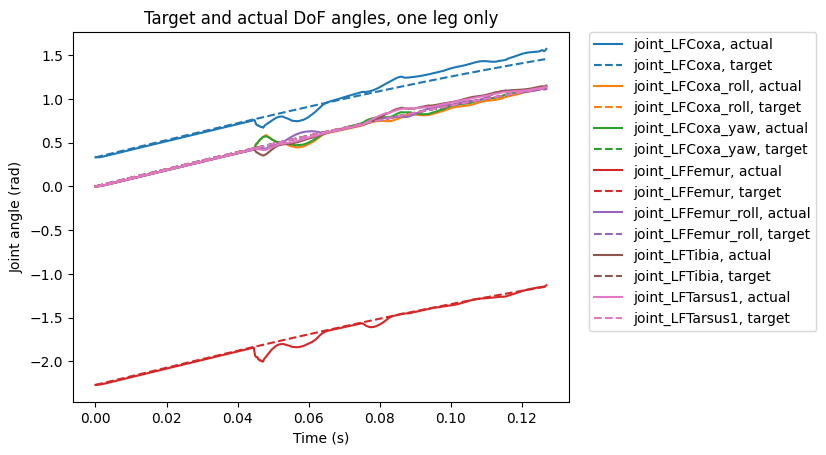

In [13]:
steps_simulated = len(obs_hist)
real_dof_angles = np.array([obs["Nuro"]["joints"][0, :7] for obs in obs_hist]).T
for i, dof in enumerate(all_leg_dofs[:7]):
    color = f"C{i}"
    plt.plot(
        times[:steps_simulated],
        real_dof_angles[i, :],
        color=color,
        linestyle="-",
        label=f"{dof}, actual",
    )
    plt.plot(
        times[:steps_simulated],
        target_dof_angles[i, :steps_simulated],
        color=color,
        linestyle="--",
        label=f"{dof}, target",
    )
plt.legend(bbox_to_anchor=(1.04, 1), borderaxespad=0)
plt.xlabel("Time (s)")
plt.ylabel("Joint angle (rad)")
plt.title("Target and actual DoF angles, one leg only")

We can see that in the beginning the actual angles follow the target angles quite well, but roughly when the fly lands on the ground, the real angles start deviating. Eventually, the simulation crashes due to unnatural poses that generate forces that are too great.

We can save the successful section of the simulation as a video:

In [14]:
camera.save_video("video.mp4")

This trivial example is clearly unrealistic in many ways. Nonetheless, we hope that we have demonstrated the basic principles of controlling NeuroMechFly. In the next notebook, we will demonstrate how to replay more realistic behaviors with NeuroMechFly.